<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Goal

The goal of this work is to design tools to:  
* Load the `bicorr_hist_master.npz` file that contains the `bicorr_hist_master` numpy array, `dt_bin_edges`, and `dict_pair_to_index`,   
* Produce histograms for select detector pairs and interaction types, 
* Plot the histograms, and
* Animate those plots. 

I will be building these tools using the `bicorr_hist_master.npz` data in `2017_03_22_pfs_combined_arrays_analysis`. This data has 1 ns bins, which is nice to work with because the data will load and plot much faster than the 0.25 ns bins.

At the time of this work, the data includes the measurements `Cf072115` and `Cf072215a`, which is about ten times as much data as in `Cf072115` alone.

In [2]:
import numpy as np
import scipy.io as sio
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import inspect

In [3]:
# Load the bicorr.py functions I have already developed
sys.path.append('../scripts')

import bicorr as bicorr

In [4]:
%load_ext autoreload
%autoreload 2

# Load the data from file

Use a function that I have already build into my `bicorr.py` functions to load the data.

In [5]:
help(bicorr.load_sparse_bhm)

Help on function load_sparse_bhm in module bicorr:

load_sparse_bhm(filepath=None, filename=None)
    Load .npz file containing `sparse_bhm`, `dict_pair_to_index`, and `dt_bin_edges`. This file was probably generated by the function `save_sparse_bhm`.
    
    Parameters
    ----------    
    filepath : str, optional
        Where is the `sparse_bhm.npz` file located? If = None, look for it in the current working directory
    filename : str, optional
        What is the name of the sparse_bhm file, if not sparse_bhm.npz?    
    
    Returns
    -------
    sparse_bhm : ndarray
        Length is equal to the number of nonzero elements in bicorr_hist_master
        dType = ('pair_i', np.uint16)  Indices in bicorr_hist_master
                ('type_i', np.uint8)    ''
                ('det1t_i', np.uint16)  ''
                ('det2t_i', np.uint16)  ''
                ('count', np.uint32)]) Number of counts 
    dt_bin_edges : ndarray
        Edges of time bin array in ns    
    note 

I'm loading some combined data so I have enough to work with.

In [5]:
sparse_bhm, dt_bin_edges = bicorr.load_sparse_bhm('../datar/')
det_df = bicorr.load_det_df()
bhm = bicorr.revive_sparse_bhm(sparse_bhm, det_df, dt_bin_edges)

In [6]:
print(sparse_bhm.shape)
print(bhm.shape)

(22554145,)
(990, 4, 250, 250)


In [7]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


# Perform event selection, produce `bicorr_hist_plot`, `bhp`

In producing the bicorrelation plot, I need to first generate a two-dimensional array that contains only the subset of data I wish to plot. I am going to separate this from the function that plots that array. The two-dimensional array will be called `bicorr_hist_plot`.

The technique for constructing `bicorr_hist_plot` should be as general and versatile as possible. I will build a function that returns `bicorr_hist_plot` from `bicorr_hist_master` and several selection options. 

## All events

Start with the simplest case, in which I want to plot all events across all detector pairs. How do I sum across all interaction types and detector pairs to produce a two-dimensional $\Delta t$ vs $\Delta t$ distribution? Start by looking at array shapes.

In [15]:
np.sum(bhm,axis=(0,1)).shape

(1000, 1000)

In [17]:
bhp = np.sum(bhm,axis=(0,1))

## Subset of interaction types

How do I select only one or some of the interaction types? The interaction type is the second argument in `bicorr_hist_master`. 

In [18]:
# Dimensions of histogram for a single event type
bhm[:,[1],:,:].shape

(990, 1, 1000, 1000)

Note: Here I use this bracket technique,

    bicorr_hist_master[:,[1],:,:],
    
rather than the following alternative without brackets,

    bicorr_hist_master[:,1,:,:],
    
because the bracket maintains the four-dimensional shape. If I did not use the bracket, the shape would change to `(990,250,250)`. Then I would have to change the `sum` technique to only sum over axis 0. By using the bracket technique, I can keep my summation more general, always summing over axes 0 and 1.

In [19]:
# Now perform the sum
np.sum(bhm[:,[1],:,:],axis=(0,1)).shape

(1000, 1000)

In [20]:
bhp = np.sum(bhm[:,[1],:,:],axis=(0,1))

## Standard notation for interaction types

I am going to produce many plots with different subsets of the data. In order to keep it organized, I will use a naming convention that encodes what event types are in that distribution.

I will have four characters to code the interaction types that are being plotted:

* If I am displaying all types, I will include `allt` at the end of the image filename.
* If not all types are included, then I will include a character for each event type. If that character is an x, that means that that interaction type is *not* included. If that character is the number of the interaction type, then that interaction type *is* included.

For instance, a plot of type 0 events only will be encoded as `0xxx`. A plot of type 0, 1, and 2 events will be encoded as `012x`. 

The subset of data specified in the previous section would be encoded with the image filename extension `_x1xx` to make it clear that only interaction type 1 is included in that distribution.

## A single detector pair

If I only want to look at data for one detector pair, then I would select within `bicorr_hist_master` along the 0th dimension. 

I will use the variable `pair_is` to mean the index of the detector pair within `bicorr_hist_master` that I am selecting.

In [33]:
dict_pair_to_index, dict_index_to_pair = bicorr.build_dict_det_pair(det_df)

In [35]:
det1 = 30
det2 = 31

pair_is = dict_pair_to_index[100*det1+det2]

np.sum(bhm[[pair_is],:,:,:],axis=(0,1)).shape

(1000, 1000)

In [37]:
bhp = np.sum(bhm[[pair_is],:,:,:],axis=(0,1))

## All pairs within a given angle range

Use the function I built in the analysis here:  
https://github.com/pfschus/fission_bicorrelation/blob/master/analysis/detector_pair_angles.ipynb

In [6]:
print(inspect.getsource(bicorr.generate_pair_is))

def generate_pair_is(det_df, th_min = None, th_max = None, i_bin = None, ignore_fc_neighbors_flag = False):
    """
    Generate list of indices of pairs within a given angle range (th_min,th_max] for bicorr_hist_master.
    
    Parameters
    ----------
    det_df : pandas dataFrame
        dataFrame of detector pair indices and angles 
    th_min : int, optional
        Exclusive lower limit (th > th_min)
    th_max : int, optional
        Inclusive upper limit (th <= th_max)  
    i_bin : int, optional
        Index of desired bin in det_df['bin']
    ignore_fc_neighbors_flag : bool, optional
        Whether to ignore channels next to fission chamber [1,17,33]
    
    Return
    ------
    pair_is : list
        Indices of detector pairs in range in bicorr_hist_master
    """
    
    # What are the conditions?    
    by_th_flag = np.logical_and(th_min is not None,th_max is not None) # True: by th range. False: by bins
    by_bin_flag = (i_bin is not None) # True: by bin range. F

In order to use this function, I need to provide the dictionary `dict_pair_to_angle`, which is built by the function `bicorr.build_dict_det_pair`. 

In [7]:
help(bicorr.build_dict_det_pair)

Help on function build_dict_det_pair in module bicorr:

build_dict_det_pair(det_df)
    Build the dictionary that converts from detector pair to index and angle
    
    Parameters
    ----------
    det_df : pandas dataFrame
        dataFrame of detector pair indices and angles   
    
    Returns
    -------
    dict_pair_to_index : dict
        keys: detector pair indices (100*det1ch+det2ch)
        values: index of pair in bicorr_hist_master (along first axis)
    dict_index_to_pair : dict
        Reverse version of dict_pair_to_index
    dict_pair_to_angle : dict
        keys: detector pair indices (100*det1ch+det2ch)
        values : angle of pair



In [42]:
dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)[2]

Remind myself what the contents of this dictionary look like.

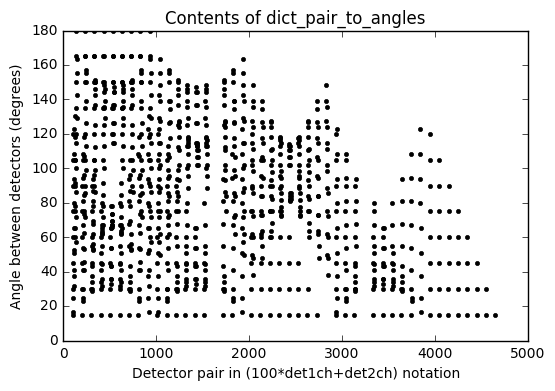

In [43]:
lists = sorted(dict_pair_to_angle.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y,'.k')
plt.xlabel('Detector pair in (100*det1ch+det2ch) notation')
plt.ylabel('Angle between detectors (degrees)')
plt.title('Contents of dict_pair_to_angles')
plt.show()

In [12]:
th_min = 0
th_max = 20
pair_is = bicorr.generate_pair_is(det_df,th_min,th_max)

This returned the detector pair corresponding indices in `bicorr_hist_master`.

In [57]:
pair_is

array([  0,   8,  44,  87, 129, 170, 210, 249, 287, 332, 360, 368, 395,
       429, 462, 494, 525, 555, 584, 620, 639, 665, 690, 714, 737, 759,
       780, 800, 837, 845, 854, 870, 885, 899, 912, 924, 935, 953, 954,
       962, 969, 975, 980, 984, 987, 989], dtype=int64)

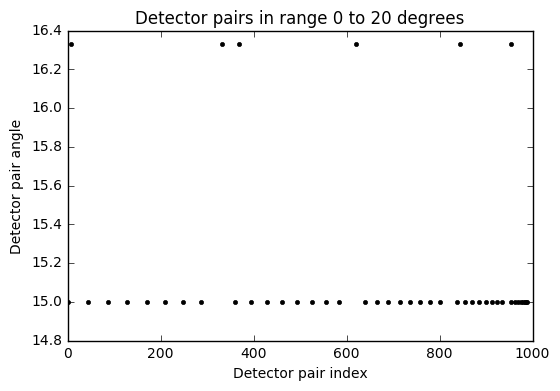

In [61]:
plt.plot(pair_is,det_df.iloc[pair_is]['angle'],'.k')
plt.xlabel('Detector pair index')
plt.ylabel('Detector pair angle')
plt.title('Detector pairs in range {} to {} degrees'.format(th_min,th_max))
plt.show()

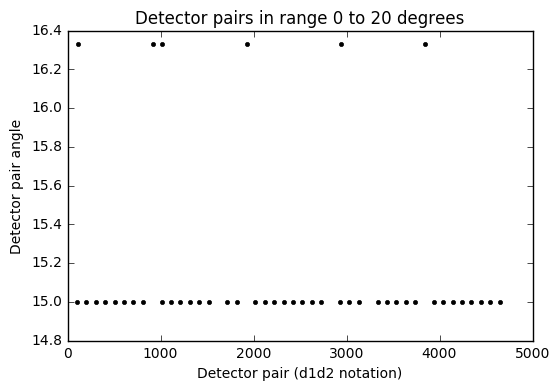

In [63]:
plt.plot(det_df.iloc[pair_is]['d1d2'],det_df.iloc[pair_is]['angle'],'.k')
plt.xlabel('Detector pair (d1d2 notation)')
plt.ylabel('Detector pair angle')
plt.title('Detector pairs in range {} to {} degrees'.format(th_min,th_max))
plt.show()

Looks good. Now select `bicorr_hist_plot` from this subset of detector pair indices `pair_is`.

In [65]:
bhp = np.sum(bhm[[pair_is],:,:,:],axis=(0,1))

## Functionalize `bicorr_hist_plot`

I am going to write a function in my `bicorr` module that will generate `bicorr_hist_plot` from `bicorr_hist_master` and the specified subset of data requested by the user. The user should be able to specify the detector pairs as `pair_is`, in terms of the index of that pair in `bicorr_hist_master`, and the interaction types in terms of (0=nn, 1=np, 2=pn, 3=pp).

In order to normalize, I will follow the technique in my other notebook here:  
https://github.com/pfschus/fission_bicorrelation/blob/master/analysis/coarsen_time_and_normalization.ipynb. The user will provide the number of fission events, and if the normalization flag `norm_flag` is set to `True`, then the distribution will be normalized by the number of fission events, the time bin width, and the number of detector pairs.

In [67]:
help(bicorr.build_bhm)

Help on function build_bhm in module bicorr:

build_bhm(det_df=None, folder_start=1, folder_end=2, dt_bin_edges=None, checkpoint_flag=True, save_flag=True, root_path=None, disable_tqdm=False, print_flag=True)
    Load bicorr_data from folder's bicorr# file and fill histogram. Loop through folders specified by `folder_start` and `folder_end`. Built for dt_bin_edges generated using default settings in bicorr.build_dt_bin_edges().
    
    Parameters
    ----------
    det_df : pandas dataFrame, optional
        dataFrame of detector pair indices and angles   
        Default is to look for the file in '../meas_info/det_df_pairs_angles.csv'
    folder_start : int, optional
        First folder
    folder_end : int, optional
        Last folder + 1 (for example, folder_end = 2 will end at folder 1)
    dt_bin_edges : ndarray, optional
        Edges of time bin array in ns
        If None, use default settings from build_dt_bin_edges()
    checkpoint_flag : bool, optional
        Generate c

Take it for a test run. First, using the print_flag, without normalization:

In [8]:
bhp = bicorr.build_bhp(bhm,dt_bin_edges)[0]

In [9]:
bhp.shape

(250, 250)

In [10]:
np.sum(bhp)

105437843.0

In [13]:
bhp = bicorr.build_bhp(bhm,dt_bin_edges, pair_is = pair_is)[0]
print(bhp.shape)
print(np.sum(bhp))

../scripts\bicorr.py:1277: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pair_is == 'all':


(250, 250)
7476624.0


Now try it with normalization:

In [14]:
fission_rate = 2.9498e+05 # fissions/s
meas_length = 5*120 + 33*120
num_fissions = (fission_rate*meas_length)

In [15]:
bhp = bicorr.build_bhp(bhm, dt_bin_edges, num_fissions = num_fissions, print_flag=True)[0]

Creating bicorr_hist_plot for...
pair_is =  all
type_is =  all
time bin width (ns) =  1.0
length of pair_is =  990
norm_factor =  1.331657712e+12


It looks like the process for constructing the `bicorr_hist_plot` array is complete. Now we need to plot it!

# Generate bicorr plots

## Try `pcolormesh` with logarithmic scale

The technique for producing the 2D histogram, `bicorr_hist_plot` was covered in the previous section. Now I need to determine the best method for visualizing that histogram.

I will use the matplotlib function `pcolormesh`, which appears to be faster than the alternative `pcolor`.

Start by producing the desired `bicorr_hist_plot`. For now, look at all detector pairs and all interaction types.

Plot and compare log vs. linear scales for the colorbar.

In [15]:
bhp.shape

(250, 250)

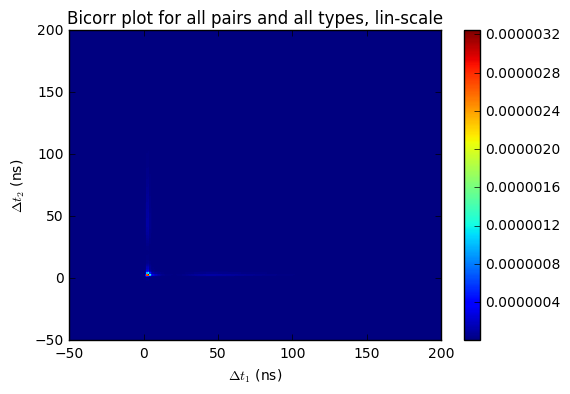

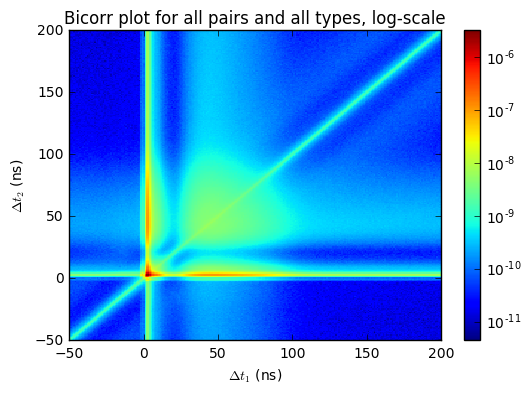

In [17]:
plt.pcolormesh(dt_bin_edges, dt_bin_edges, bhp) # pcolormesh faster than pcolor
plt.colorbar()
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr plot for all pairs and all types, lin-scale')
plt.show()

plt.pcolormesh(dt_bin_edges, dt_bin_edges, bhp, norm=matplotlib.colors.LogNorm()) # pcolormesh faster than pcolor
plt.colorbar()
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr plot for all pairs and all types, log-scale')
plt.show()

For this data, it is important to use the logarithmic scale so that the non-gg features are visible. 

## Set `vmin`, `vmax` colorbar range

In some cases I will need to fix the colorbar range between multiple plots, so I should provide that as an input parameter. I will make use of the optional status of `vmin` and `vmax` in `pcolormax` and set their default to `None`. 

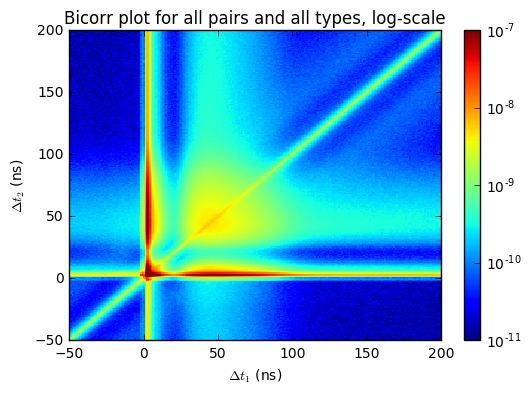

In [20]:
plt.pcolormesh(dt_bin_edges, dt_bin_edges, bhp, norm=matplotlib.colors.LogNorm()
              ,vmin=1e-11,vmax=1e-7) # pcolormesh faster than pcolor
plt.colorbar()
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr plot for all pairs and all types, log-scale')
plt.show()

This "flattens" the colorbar by making anything outside of the range between `vmin` and `vmax` dark blue or dark red. 

## Look at subsets of data

Using the versatility I built into `bicorr.build_bicorr_hist_plot()`, look at different conditions and subsets of data in `bicorr_hist_plot`. 

First, look only at nn events.

Creating bicorr_hist_plot for...
pair_is =  all
type_is =  [0]
time bin width (ns) =  1.0
length of pair_is =  990
norm_factor =  1


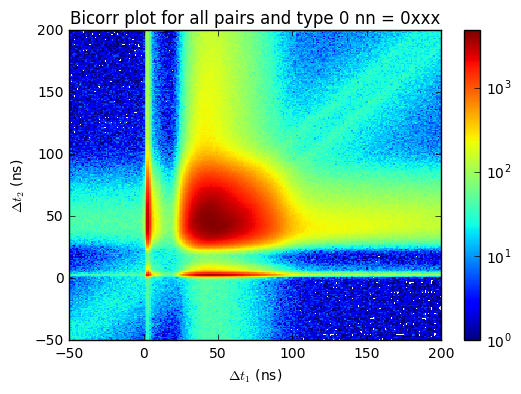

In [22]:
bhp = bicorr.build_bhp(bhm, dt_bin_edges, type_is = [0], print_flag=True)[0]

plt.pcolormesh(dt_bin_edges, dt_bin_edges, bhp, norm=matplotlib.colors.LogNorm()) # pcolormesh faster than pcolor
plt.colorbar()
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr plot for all pairs and type 0 nn = 0xxx')
plt.show()

Now everything for a given pair.

In [16]:
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)

Creating bicorr_hist_plot for...
pair_is =  [0]
type_is =  all
time bin width (ns) =  1.0
length of pair_is =  1
norm_factor =  1


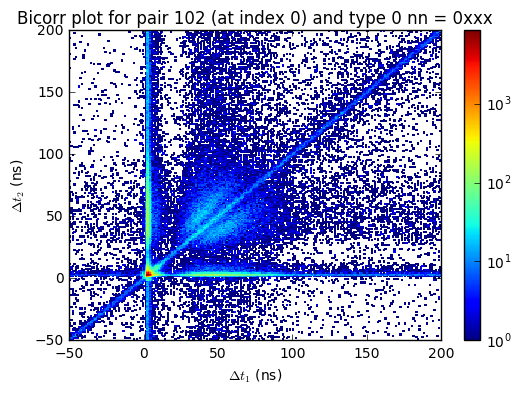

In [17]:
i = dict_pair_to_index[102]
bhp = bicorr.build_bhp(bhm, dt_bin_edges, pair_is = [i], print_flag=True)[0]

plt.pcolormesh(dt_bin_edges, dt_bin_edges, bhp, norm=matplotlib.colors.LogNorm()) # pcolormesh faster than pcolor
plt.colorbar()
plt.xlabel('$\Delta t_1$ (ns)')
plt.ylabel('$\Delta t_2$ (ns)')
plt.title('Bicorr plot for pair 102 (at index {}) and type 0 nn = 0xxx'.format(i))
plt.show()

## Functionalize `bicorr_plot`

Make a general `bicorr_plot` function that takes `bicorr_hist_plot` as an input parameter. View the contents here:

In [18]:
print(inspect.getsource(bicorr.bicorr_plot))

def bicorr_plot(bicorr_hist_plot, dt_bin_edges, title = None,
                vmin = None, vmax = None,
                save_flag = False, save_filename = 'bicorr', save_folder = 'fig', show_flag = False):
    """
    Creates 2d bicorr hist plot
    
    Parameters
    ----------
    bicorr_hist_plot : ndarray
        Array to plot. Two-dimensional with axes sizes corresponding to dt_bin_edges x dt_bin_edges.
    dt_bin_edges : ndarray
        One-dimensional array of time bin edges
    title : str, optional
    vmin : float, optional
        Minimum of colorbar range
    vmax : float, optional
        Maximum of colorbar range
    save_flag : bool, optional
        Do you want to save to disk using function save_fig_to_folder
    save_filename : str, optional
        Filename for bicorrelation image (.png will be added)
    save_folder : str, optional
        Destination folder location for storing bicorrelation image
    show_flag : bool, optional   
        Display plot to current s

Try it out with lots of different options.

In [19]:
bhp = bicorr.build_bhp(bhm,dt_bin_edges,print_flag=True)[0]

Creating bicorr_hist_plot for...
pair_is =  all
type_is =  all
time bin width (ns) =  1.0
length of pair_is =  990
norm_factor =  1


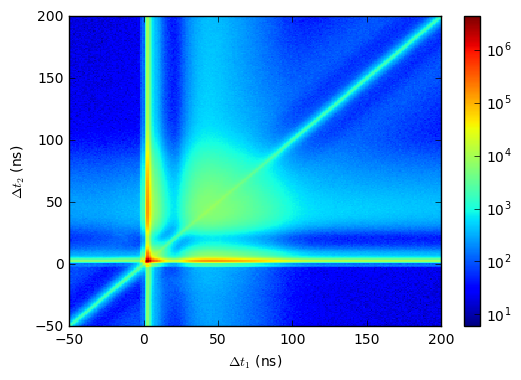

In [20]:
bicorr.bicorr_plot(bhp,dt_bin_edges, show_flag = True)

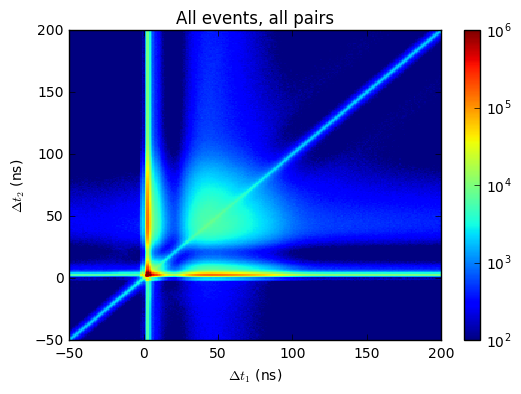

In [21]:
bicorr.bicorr_plot(bhp,dt_bin_edges, show_flag = True, title='All events, all pairs'
                   , vmin = 1e2, vmax = 1e6)

Looks like it is working great.

# Generate animation vs. detector pair angle

There is a summary of my method for organizing detector pairs by their angles in my notebook here:  
<https://github.com/pfschus/fission_bicorrelation/blob/master/analysis/detector_pair_angles.ipynb>

The steps in the process will be

1) Load detector pair angle information  
2) Sort detector pairs by angle  
3) Generate a bicorrelation plot at each angle, save to file  
4) Stitch together in a .gif animation  

## Step 1) Load detector pair angle information

In [22]:
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)

I also need to create vectors of the detector numbers and the angle between them, so I built the following function to unpack the dictionary into those vectors. 

In [23]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()

I can see the angle between detector pairs by plotting `det1ch`, `det2ch`, and `angle` in a square scatter plot as shown below:

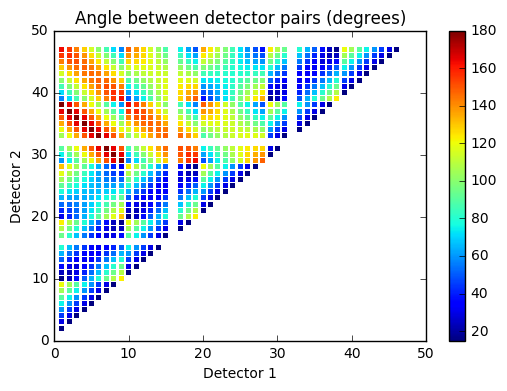

In [24]:
plt.scatter(det_df['d1'],det_df['d2'],c=det_df['angle'],s=13,marker='s',edgecolor='none')
plt.colorbar()
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('Detector 1')
plt.ylabel('Detector 2')
plt.title('Angle between detector pairs (degrees)')
plt.savefig('../fig/angle_btw_pairs.png')
plt.show()

What does the distribution of these detector angles look like?

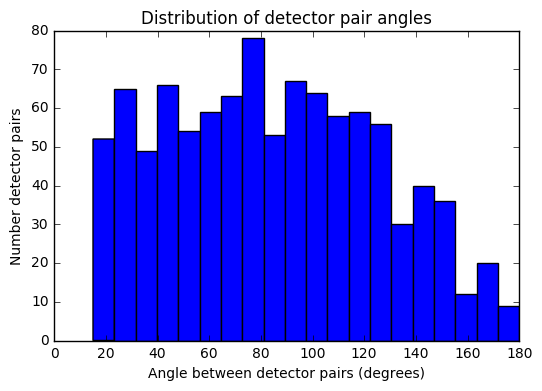

In [25]:
plt.hist(det_df['angle'],20)
plt.xlabel('Angle between detector pairs (degrees)')
plt.ylabel('Number detector pairs')
plt.title('Distribution of detector pair angles')
plt.savefig('../fig/dist_angles.png')
plt.show()

## Step 2) Sort detector pairs by angle

Now I need to select detector pairs within a given angle range and store those pairs' indices to `pair_is`. Break it up into 20 degree bins.

In [26]:
th_bin_edges = np.arange(0,181,20)
print(th_bin_edges)

[  0  20  40  60  80 100 120 140 160 180]


Use the function I wrote, `bicorr.generate_pair_is_th_range`, for generating `pair_is` given `th_min` and `th_max` (explained in  
<https://github.com/pfschus/fission_bicorrelation/blob/master/analysis/detector_pair_angles.ipynb>).

In [27]:
help(bicorr.generate_pair_is)

Help on function generate_pair_is in module bicorr:

generate_pair_is(det_df, th_min=None, th_max=None, i_bin=None)
    Generate list of indices of pairs within a given angle range (th_min,th_max] for bicorr_hist_master.
    
    Parameters
    ----------
    det_df : pandas dataFrame
        dataFrame of detector pair indices and angles 
    th_min : int, optional
        Exclusive lower limit (th > th_min)
    th_max : int, optional
        Inclusive upper limit (th <= th_max)  
    i_bin : int, optional
        Index of desired bin in det_df['bin']
    
    Return
    ------
    pair_is : list
        Indices of detector pairs in range in bicorr_hist_master



In [41]:
th_min = th_bin_edges[0]
th_max = th_bin_edges[1]
pair_is = bicorr.generate_pair_is(det_df,th_min=th_min,th_max=th_max)
print(pair_is)

[  0   8  44  87 129 170 210 249 287 332 360 368 395 429 462 494 525 555
 584 620 639 665 690 714 737 759 780 800 837 845 854 870 885 899 912 924
 935 953 954 962 969 975 980 984 987 989]


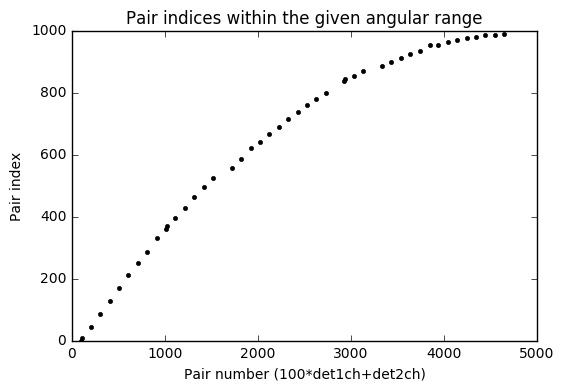

In [29]:
plt.plot(det_df.iloc[pair_is]['d1d2'],pair_is,'.k')
plt.xlabel('Pair number (100*det1ch+det2ch)')
plt.ylabel('Pair index')
plt.title('Pair indices within the given angular range')
plt.show()

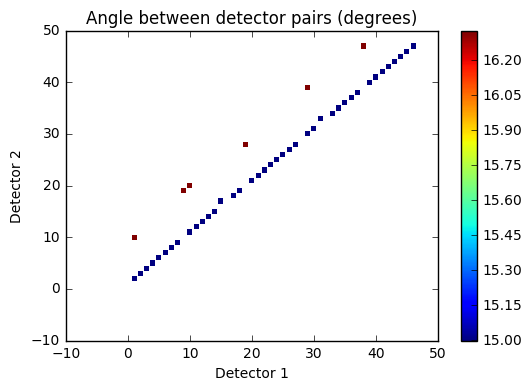

In [30]:
plt.scatter(det_df.iloc[pair_is]['d1'],det_df.iloc[pair_is]['d2'],c=list(det_df.iloc[pair_is]['angle']),s=13,marker='s',edgecolor='none')
plt.colorbar()
plt.xlabel('Detector 1')
plt.ylabel('Detector 2')
plt.title('Angle between detector pairs (degrees)')
plt.show()

## Step 3) Generate a bicorrelation plot at each angle, save to file

Loop through the angle ranges defined by `th_bin_edges` and produce a bicorrelation plot at each angle. For now, include all event types, and print the output.

The colorbar range will vary across all of the plots. I should generate `bicorr_hist_plot` for all angles and then calculate the overall max and min, then plot all bicorrelation plots with the same `vmax` and `vmix`.

Instead of making `bicorr_hist_plot` only two dimensions, I will add a third dimension for the angle range. 

In [31]:
bhp = np.zeros([len(th_bin_edges)-1,len(dt_bin_edges)-1,len(dt_bin_edges)-1])

In [32]:
bhp.shape

(9, 250, 250)

In [44]:
fission_rate = 2.9498e+05 # fissions/s
meas_length = 5*120 + 33*120
num_fissions = (fission_rate*meas_length)

for th_i in np.arange(0,len(th_bin_edges)-1):
    th_min = th_bin_edges[th_i]
    th_max = th_bin_edges[th_i+1]
    
    
    pair_is = bicorr.generate_pair_is(det_df,th_min=th_min,th_max=th_max)
    
    bhp[th_i,:,:] = bicorr.build_bhp(bhm, dt_bin_edges,num_fissions=num_fissions,pair_is = pair_is, print_flag=True)[0]

Creating bicorr_hist_plot for...
pair_is =  [  0   8  44  87 129 170 210 249 287 332 360 368 395 429 462 494 525 555
 584 620 639 665 690 714 737 759 780 800 837 845 854 870 885 899 912 924
 935 953 954 962 969 975 980 984 987 989]
type_is =  all
time bin width (ns) =  1.0
length of pair_is =  46
norm_factor =  61875004800.0
Creating bicorr_hist_plot for...
pair_is =  [  1   9  10  17  45  51  52  53  88  93  94  95  96 130 136 137 138 171
 177 178 179 211 217 218 219 250 256 257 258 259 294 295 296 330 331 341
 361 369 370 396 402 403 404 430 435 436 437 438 463 469 470 471 495 501
 502 503 526 532 533 534 556 562 563 564 565 591 592 593 618 619 640 656
 666 691 715 738 760 781 836 838 846 847 855 861 862 863 871 876 877 878
 879 886 892 893 894 900 906 907 908 913 919 920 921 925 931 932 933 934
 942 943 944 951 952 955 963 970 976 981 985 988]
type_is =  all
time bin width (ns) =  1.0
length of pair_is =  120
norm_factor =  161413056000.0
Creating bicorr_hist_plot for...
pair_is =  

Now calculate `vmin` and `vmax` from all of the data in `bicorr_hist_plot`. There are many empty bins still with magnitude zero, so I need to calculate `vmin` as the minimum of the nonzero data.

In [45]:
vmin = np.min(bhp[np.nonzero(bhp)])
vmax = np.max(bhp)

print(vmin,vmax)

4.45170230995e-12 6.72518735708e-06


I am going to save the plots to `.png` files in a local folder, and then stitch them together in a `.gif`. 

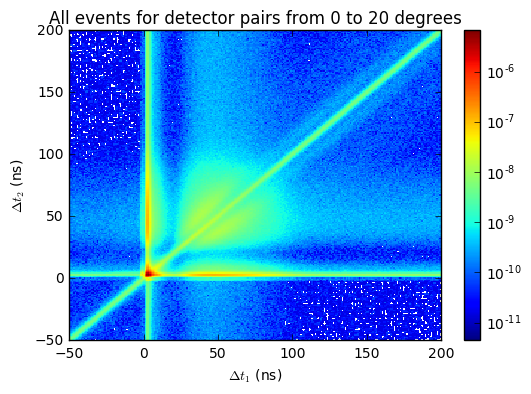

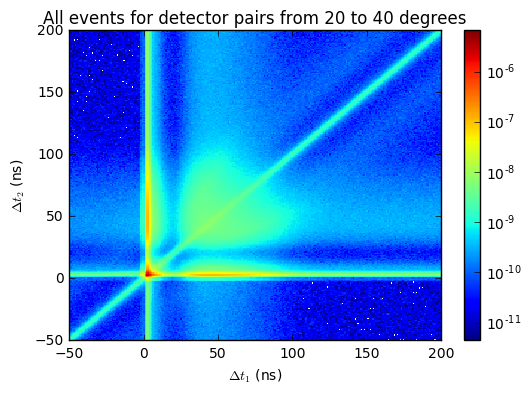

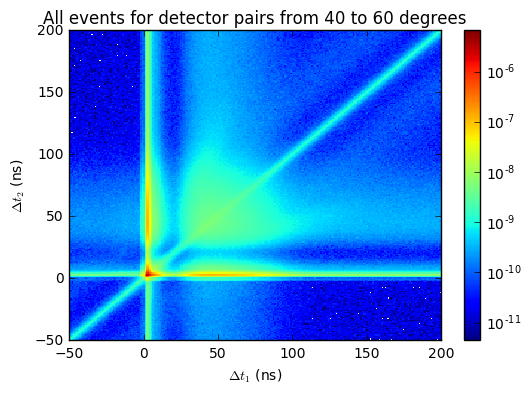

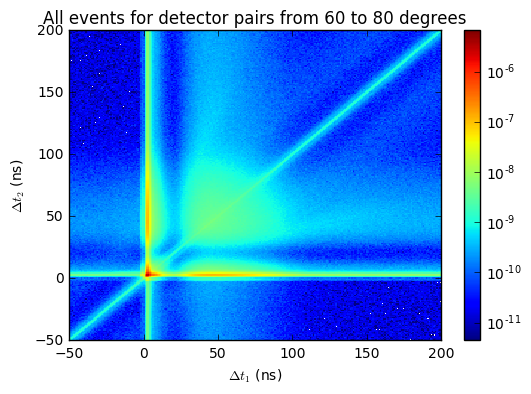

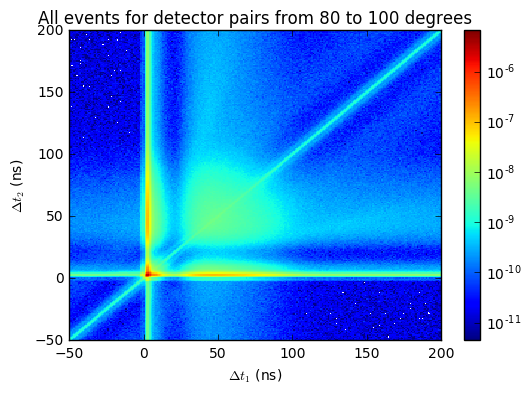

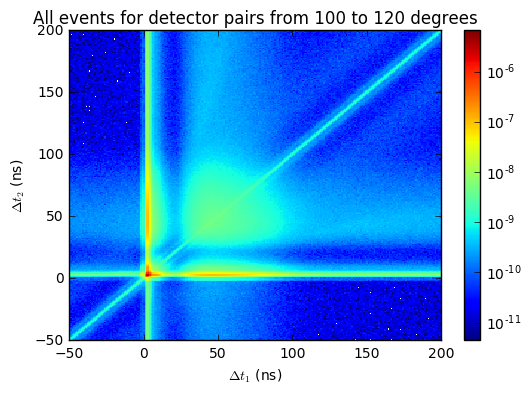

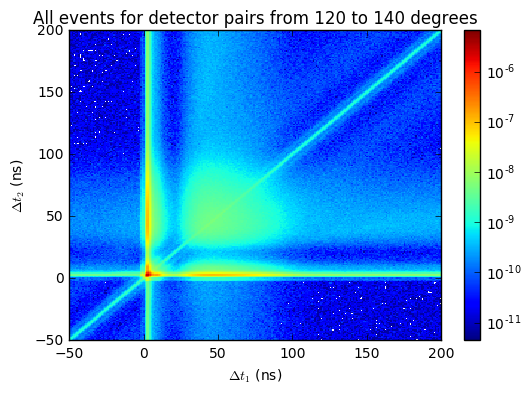

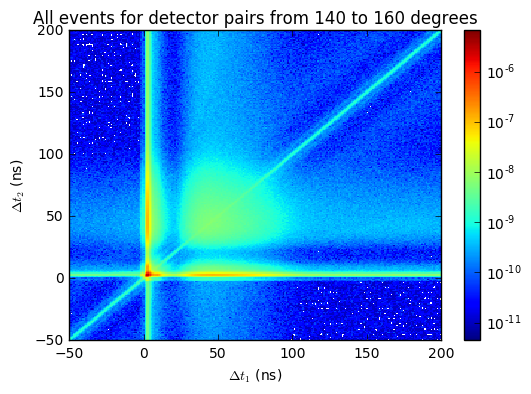

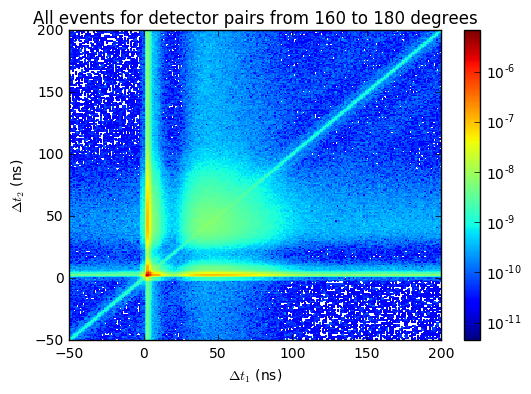

In [47]:
filenames = []

for th_i in np.arange(0,len(th_bin_edges)-1):
    th_min = th_bin_edges[th_i]
    th_max = th_bin_edges[th_i+1]
    
    save_filename = r'bicorr_plot_{:03d}_{:03d}'.format(th_min,th_max)    
    filenames.append(save_filename)
    
    bicorr.bicorr_plot(bhp[th_i,:], dt_bin_edges, title="All events for detector pairs from {} to {} degrees".format(th_min,th_max), vmin = vmin, vmax = vmax, save_flag = True, save_filename = save_filename, save_folder = '../fig/animate/', show_flag = True)    

## Step 4) Stitch together in a `.gif` animation

Try the technique shown on this StackOverflow:  
http://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

I am essentially going to load each of the images I just saved and tack it on to the end of a `.gif` that I am building.

In [48]:
print(filenames)

['bicorr_plot_000_020', 'bicorr_plot_020_040', 'bicorr_plot_040_060', 'bicorr_plot_060_080', 'bicorr_plot_080_100', 'bicorr_plot_100_120', 'bicorr_plot_120_140', 'bicorr_plot_140_160', 'bicorr_plot_160_180']


In [49]:
import imageio
help(imageio.mimsave)

Help on function mimwrite in module imageio.core.functions:

mimwrite(uri, ims, format=None, **kwargs)
    mimwrite(uri, ims, format=None, **kwargs)
    
    Write multiple images to the specified file.
    
    Parameters
    ----------
    uri : {str, file}
        The resource to write the images to. This can be a normal
        filename, a file in a zipfile, a file object, or
        ``imageio.RETURN_BYTES``, in which case the raw bytes are
        returned.
    ims : sequence of numpy arrays
        The image data. Each array must be NxM, NxMx3 or NxMx4.
    format : str
        The format to use to read the file. By default imageio selects
        the appropriate for you based on the filename and its contents.
    kwargs : ...
        Further keyword arguments are passed to the writer. See :func:`.help`
        to see what arguments are available for a particular format.



In [50]:
images = []
for filename in filenames:
    images.append(imageio.imread('../fig/animate/'+filename+'.png'))
imageio.mimsave('../fig/animate/all.gif', images, fps=1)

The `.gif` is now saved to file. Can I view it here in the jupyter notebook? Use a markdown cell and the following code:

    <img src="fig/all.gif">

<img src="fig/all.gif">

## All commands together

When I do this in the future, I want to be able to quickly copy and paste all of the commands. Put them here.

In [52]:
# Produce important variables for detector indices, pairs
det_df = bicorr.load_det_df()
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()

In [53]:
# Specify angle bins
th_bin_edges = np.arange(0,181,20)

# Set up bicorr_hist_plot
bhp = np.zeros([len(th_bin_edges)-1,len(dt_bin_edges)-1,len(dt_bin_edges)-1])

In [57]:
# Calculate number of fissions based on measurement
fission_rate = 2.9498e+05 # fissions/s
meas_length = 5*120 + 33*120
num_fissions = (fission_rate*meas_length)

for th_i in np.arange(0,len(th_bin_edges)-1):
    th_min = th_bin_edges[th_i]
    th_max = th_bin_edges[th_i+1]
        
    pair_is = bicorr.generate_pair_is(det_df,th_min=th_min,th_max=th_max)
    
    bhp[th_i,:,:] = bicorr.build_bhp(bhm, dt_bin_edges,num_fissions=num_fissions,pair_is = pair_is, print_flag=False)[0]
    
# Calculate colorbar range
vmin = np.min(bhp[np.nonzero(bhp)])
vmax = np.max(bhp)

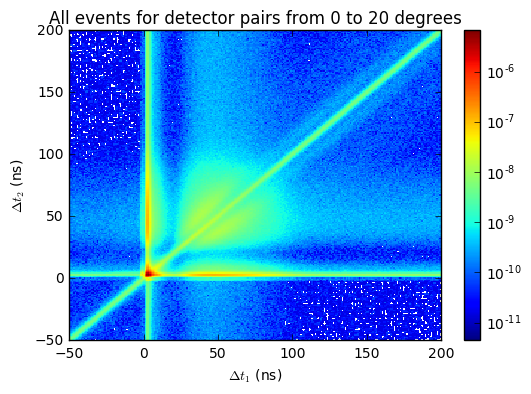

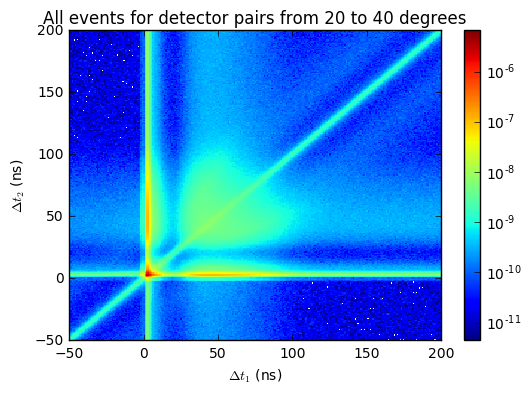

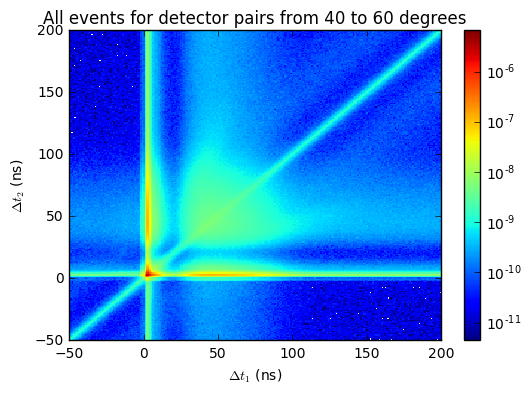

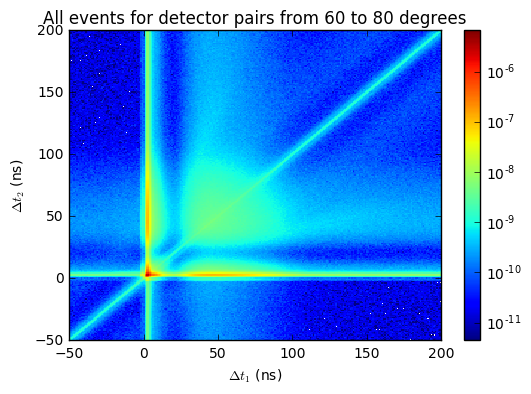

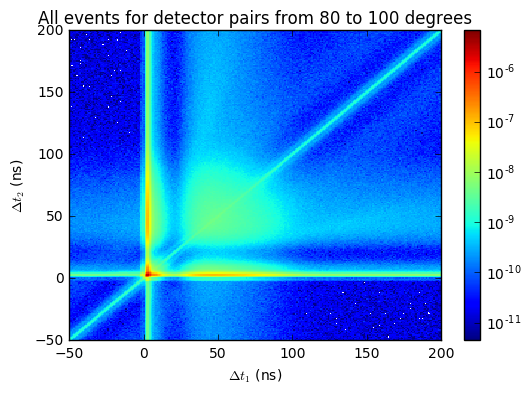

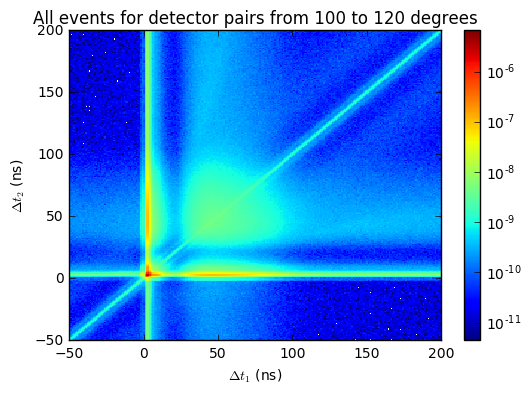

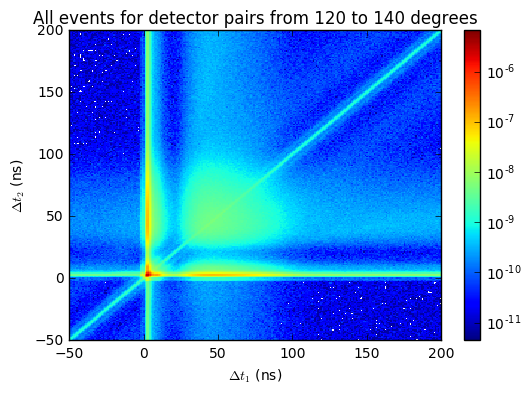

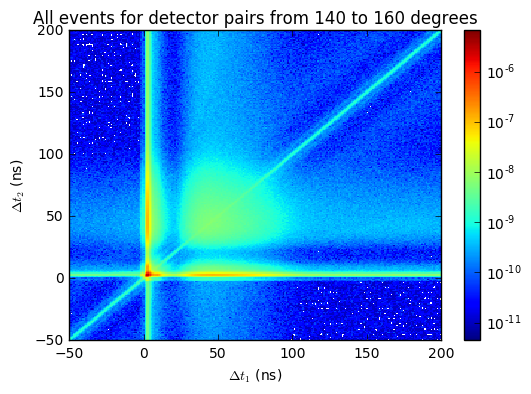

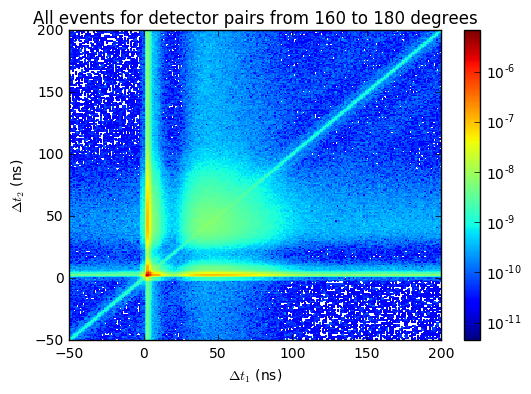

In [58]:
filenames = []

for th_i in np.arange(0,len(th_bin_edges)-1):
    th_min = th_bin_edges[th_i]
    th_max = th_bin_edges[th_i+1]
    
    save_filename = r'bicorr_plot_{:03d}_{:03d}'.format(th_min,th_max)    
    filenames.append(save_filename)
    
    bicorr.bicorr_plot(bhp[th_i,:], dt_bin_edges, title="All events for detector pairs from {} to {} degrees".format(th_min,th_max), vmin = vmin, vmax = vmax, save_flag = True, save_filename = save_filename, save_folder = '../fig/animate/', show_flag = True)    

In [60]:
images = []
for filename in filenames:
    images.append(imageio.imread('../fig/animate/'+filename+'.png'))
imageio.mimsave('../fig/animate/all.gif', images, fps=1)

`<img src="fig/all.gif">`

<img src="fig/all.gif">